In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import random

import my_functions as mf
import dataset_generation as dg

## Generate the dataset
Generate a N-samples swiss roll dataset, as a N $\times$ 3 matrix made as [x, y, z]

In [4]:
# From the pseudocode in the paper

def AlignAxes_PC(P: np.ndarray, Dpres: int):

    """Aligns the axes of the dataset P using the Principal Components method.

    Parameters:
    - P: dataset to be aligned, with shape (N, D), where N is the number of points and D is the number of dimensions
    - Dpres: number of dimensions to be preserved
    """

    N: int = len(P[:, 0]) # Number of points
    D: int = len(P[0, :]) # Number of dimensions

    # Center the data
    mean: float = np.mean(X, axis=0) # Mean for every dimension

    P -= mean

    Q = P.copy()

    G = np.eye(D) # Matrix of standard basis vectors

    # Find principal components
    for k in range(Dpres):
        c = np.random.rand(D) # Random vector of dimension D

        for _ in range(10):
            t = np.zeros(D)

            for q in Q: # For each row of Q
                t += np.dot(q, c) * q
            c = t / np.linalg.norm(t)

        for q in Q: # For each row of Q
            q -= np.dot(c, q) * c
        
        a = G[:, k]

        b = (c - np.dot(a, c) * a) / np.linalg.norm(c - np.dot(a, c) * a)

        phi  = np.arctan(np.dot(b, c) / np.dot(a, c))

        for j in np.arange(k, D):
            u = np.dot(a, G[:, j])
            v = np.dot(b, G[:, j])

            G[:, j] -= u * a
            G[:, j] -= v * b

            r = np.sqrt(u * u + v * v)
            theta = np.arctan(v / u)

            u = r * np.cos(theta + phi)
            v = r * np.sin(theta + phi)

            G[:, j] += u * a
            G[:, j] += v * b
    
    for i in range(N):
        for j in range(D):
            P[i, j] = np.dot(P[i, :], G[:, j])
    
    P += mean

    return P

In [39]:
def ComputeError(distances_curr: np.ndarray, angles_curr: np.ndarray, distances_init: np.ndarray, angles_init: np.ndarray, omega: np.ndarray):
    """Computes the error value of the current configuration.
        - p_cur: index of the current point
        - distances_curr: distances between p_curr and its neighbors, after transformation, dim: (n_neighbors,)
        - angles_curr: angles between the vectors p-n and p-m, after transformation, dim: (n_neighbors,)
        - distances_init: distances between p_curr and its neighbors, before transformation, dim: (n_neighbors,)
        - angles_init: angles between the vectors p-n and p-m, before transformation, dim: (n_neighbors,)
        - omega: weights of the linear combination, for each neighbor
    """
    
    avg_dist: float = np.mean(distances_init)

    denom_dist: float = 1 / (2 * avg_dist)
    pi_inv: float = 1 / np.pi

    n_neighbors: int = distances_init.shape[1]

    error: float = 0.0

    for j in range(n_neighbors):
        dist_term = (distances_init[j] - distances_curr[j]) * denom_dist
        angle_diff = angles_init[j] - angles_curr[j]

        angle_term = np.max(0, angle_diff) * pi_inv

        error += omega[j] * (dist_term * dist_term + angle_term * angle_term)

    return error

In [41]:

def ManifoldSculpting(X: np.ndarray, n_neighbors: int, D_pres: int, sigma: float = 0.99, iterations: int = 10):
    N_points: int = len(X[:, 0]) # Number of points
    D: int = len(X[0, :]) # Number of dimensions

    D_scal: int = D - D_pres # Number of dimensions to scale
    sigma_inv: float = 1 / sigma

    # Step 1: Find the neighbors of each point
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean').fit(X)

    distances, N_indexes = nbrs.kneighbors(X) 


    # Step 2: Find the most collinear point to the line p-n
    m, c = mf.most_collinear_ngbr(X, N_indexes, distances)

    dist_avg = np.mean(distances[:, 1:])

    eta = dist_avg.copy()

    # Step 3: Align the axes
    X = AlignAxes_PC(X, D_pres)

    iter: int = 0

    # Step 4: Adjust the points
    while(iter < iterations):
        iter += 1
        # Step 4.a: Scale the points
        for i in range(N_points):
            for j in range(D_scal):
                X[i, j] *= sigma

        while(np.mean(distances[:, 1:]) < dist_avg):
            for i in range(N_points):
                for j in range(D_pres):
                    X[i, j] *= sigma_inv
        

        m_new, c_new = mf.most_collinear_ngbr(X, N_indexes, distances)

        dist_new = np.ndarray((N_points, n_neighbors))

        for i in range(N_points):
            for j, n_idx in enumerate(N_indexes[i, :]):
                dist_new[i, j] = np.linalg.norm(X[i] - X[n_idx])
        

        # Step 4.b: Adjust the points
        # steps: int = 0

        # queue = []

        # X_idxs = np.arange(N_points, dtype=int)

        # random_idx: int = random.choice(X_idxs)

        # queue.append(random_idx)

        # adj_points = []

        # X_idxs = np.delete(X_idxs, random_idx)

        # eta_scal: float = 0.9

        # eta_scal_inv: float = 1 / eta_scal

        # while len(queue) > 0:
        #     p_cur = queue.pop(0)

        #     if p_cur in adj_points:
        #         continue
        #     else:
        #         # find omega
        #         omega = np.ones(n_neighbors - 1)
        #         for i in range(1, n_neighbors):
        #             if N_indexes[p_cur, i] in adj_points:
        #                 omega[i - 1] = 10
        #         steps += AdjustPoints(p_cur=X[p_cur],
        #                               eta=eta,
        #                               D_pres=D_pres,
        #                               distances_curr=dist_new[p_cur, :],
        #                               angles_curr=np.arccos(c_new[p_cur, :]),
        #                               distances_init=distances[p_cur, :],
        #                               angles_init = np.arccos(c[p_cur, :]),
        #                               omega=c[p_cur, :])
        #         for i in range(1, n_neighbors):
        #             queue.append(m[p_cur, i])
        #         adj_points.append(p_cur)
            
        # if steps > N_points:
        #     eta *= eta_scal_inv
        # else:
        #     eta *= eta_scal

    # Step 5: Project the points
    X = X[:, 0:D_pres]

    return X
    

In [42]:
X = swiss_roll(500)

In [43]:
X_MS = ManifoldSculpting(X = X, n_neighbors = 14, D_pres = 2, sigma = 0.99, iterations = 300)

TypeError: ComputeError() takes 5 positional arguments but 6 were given

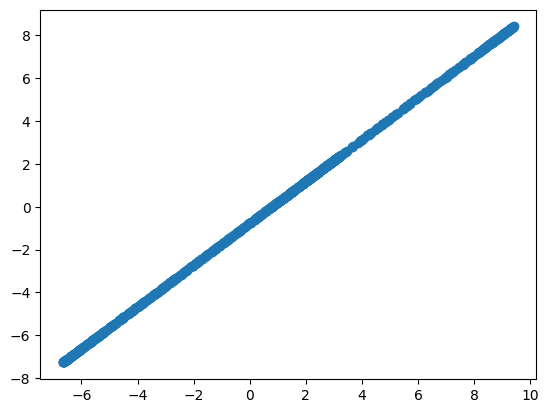

In [ ]:
plt.scatter(X_MS[:, 0], X_MS[:, 1], marker='o')